# Technical Evaluation:
Logical Flow: Your notebook follows the "Gold Standard" for competition notebooks by separating Configuration, Architecture, Utilities, and Inference. This is exactly how top-tier Kaggle solutions are organized.

Resource Management: You have both GPU T4s active, and your data sources (cnndinov2-pbd, dinov2, and the competition images) are correctly mounted in the /kaggle/input directory.

Output Ready: Your /kaggle/working directory is clean and ready to receive the submission.csv.

Final Winning Checklist before "Save Version":
Before you click that Save Version button to submit, do a quick "sanity check" on these three things:

Internet Toggle: Ensure the Internet setting in the right-hand sidebar is Off. Most code competitions will fail your submission if the internet is on during the run.

Persistence: Ensure your CFG.model_weights path exactly matches the path shown in your Input sidebar (it looks correct based on our previous fix).

The Visualization Cell: Since you added the visualization cell, make sure you ran Cell 4 first so that the results and mask variables are available in memory.

# Cell 1: Environment Setup & Configuration
This cell handles imports, global settings, and reproducibility.

In [1]:
import os, cv2, json, math, torch, random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel

class CFG:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 518  # Optimal multiple of 14 for DINOv2
    
    # Dataset Paths
    test_dir = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
    sample_sub = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
    dino_path = "/kaggle/input/dinov2/pytorch/base/1"
    model_weights = "/kaggle/input/cnndinov2-pbd/CNNDINOv2-U52/CNNDINOv2-U52/model_seg_final.pt"
    
    # Inference Hyperparameters
    area_thr = 350    
    mean_thr = 0.28   
    use_tta = True

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)
print(f"--- Environment Ready. Device: {CFG.device} ---")

2026-01-08 21:16:00.814789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767906961.002173      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767906961.056908      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767906961.500993      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767906961.501029      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767906961.501031      24 computation_placer.cc:177] computation placer alr

--- Environment Ready. Device: cuda ---


# Cell 2: Model Architecture
This architecture is specifically designed to match your saved .pt weights and uses the DINOv2 feature extractor.

In [2]:
class DinoTinyDecoder(nn.Module):
    def __init__(self, in_ch=768, out_ch=1):
        super().__init__()
        # Explicitly matches saved state_dict keys: "seg_head.blockX"
        self.block1 = nn.Sequential(nn.Conv2d(in_ch, 384, 3, padding=1), nn.ReLU(inplace=True))
        self.block2 = nn.Sequential(nn.Conv2d(384, 192, 3, padding=1), nn.ReLU(inplace=True))
        self.block3 = nn.Sequential(nn.Conv2d(192, 96, 3, padding=1), nn.ReLU(inplace=True))
        self.conv_out = nn.Conv2d(96, out_ch, kernel_size=1)
    
    def forward(self, f, target_size):
        # Multi-stage upsampling to recover spatial resolution
        x = F.interpolate(self.block1(f), size=(74, 74), mode='bilinear', align_corners=False)
        x = F.interpolate(self.block2(x), size=(148, 148), mode='bilinear', align_corners=False)
        x = F.interpolate(self.block3(x), size=(296, 296), mode='bilinear', align_corners=False)
        x = self.conv_out(x)
        return F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)

class ScientificForgeryModel(nn.Module):
    def __init__(self, dino_path):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(dino_path, local_files_only=True)
        self.encoder = AutoModel.from_pretrained(dino_path, local_files_only=True)
        for p in self.encoder.parameters(): p.requires_grad = False # Freeze backbone
        self.seg_head = DinoTinyDecoder(768, 1)

    def forward(self, x):
        imgs = (x * 255).clamp(0, 255).byte().permute(0, 2, 3, 1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(CFG.device)
        with torch.no_grad():
            feats = self.encoder(**inputs).last_hidden_state
        B, N, C = feats.shape
        s = int(math.sqrt(N-1))
        fmap = feats[:, 1:, :].permute(0, 2, 1).reshape(B, C, s, s)
        return self.seg_head(fmap, (CFG.img_size, CFG.img_size))

# Cell 3: Post-Processing & RLE Utilities
Functions to clean the noise and format the output according to Kaggle's specific RLE rules.

In [3]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    dots = np.where(pixels == 1)[0]
    if len(dots) == 0: return "authentic"
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1: run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return json.dumps([int(x) for x in run_lengths])

def post_process(prob, original_size):
    # Denoising and adaptive thresholding
    prob_refined = cv2.GaussianBlur(prob, (5, 5), 0)
    thr = np.mean(prob_refined) + 0.35 * np.std(prob_refined)
    mask = (prob_refined > thr).astype(np.uint8)
    # Morphological closing to fill small holes in the mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.resize(mask, original_size, interpolation=cv2.INTER_NEAREST)
    return mask

# Cell 4: Final Inference & Submission Creation
The main loop that runs the model and produces the submission.csv file with correct data types.

In [4]:
def run_winning_inference():
    # Initialize Model
    model = ScientificForgeryModel(CFG.dino_path).to(CFG.device)
    
    # Load Weights with flexible naming compatibility
    if os.path.exists(CFG.model_weights):
        state_dict = torch.load(CFG.model_weights, map_location=CFG.device)
        model.load_state_dict(state_dict, strict=False)
        print("--- Trained Decoder Weights Loaded ---")
    
    model.eval()
    results = []
    # Using a local 'last_mask' variable to return at the end
    last_mask = None
    test_images = sorted(os.listdir(CFG.test_dir))

    if not test_images:
        print("⚠️ No test images found!")
        return [], None

    with torch.no_grad():
        for img_name in tqdm(test_images, desc="Inference"):
            img_path = os.path.join(CFG.test_dir, img_name)
            pil_img = Image.open(img_path).convert("RGB")
            orig_w, orig_h = pil_img.size
            
            # Prepare tensor
            img_t = torch.from_numpy(np.array(pil_img.resize((CFG.img_size, CFG.img_size)), np.float32)/255.).permute(2,0,1)[None].to(CFG.device)
            
            # Predict with TTA
            logits = model(img_t)
            if CFG.use_tta:
                logits_h = model(torch.flip(img_t, dims=[3]))
                logits = (logits + torch.flip(logits_h, dims=[3])) / 2.0
            
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()
            mask = post_process(prob, (orig_w, orig_h))
            last_mask = mask # Save the last mask for visualization
            
            # Validation Logic: Is it forged or authentic?
            area = mask.sum()
            mask_s = cv2.resize(mask, (CFG.img_size, CFG.img_size), interpolation=cv2.INTER_NEAREST)
            mean_c = prob[mask_s == 1].mean() if area > 0 else 0
            
            if area >= CFG.area_thr and mean_c >= CFG.mean_thr:
                annotation = rle_encode(mask)
            else:
                annotation = "authentic"
            
            results.append({"case_id": str(Path(img_name).stem), "annotation": annotation})

    # Prepare final dataframe and match Case_ID types
    sub_df = pd.DataFrame(results)
    sample_df = pd.read_csv(CFG.sample_sub)
    
    sample_df['case_id'] = sample_df['case_id'].astype(str)
    sub_df['case_id'] = sub_df['case_id'].astype(str)
    
    final_sub = sample_df[['case_id']].merge(sub_df, on="case_id", how="left").fillna("authentic")
    final_sub.to_csv("submission.csv", index=False)
    
    print("--- Process Finished. submission.csv is ready for submission! ---")
    
    # Return values so they can be accessed globally by the next cell
    return results, last_mask

if __name__ == "__main__":
    # Capturing the returned values globally
    results, mask = run_winning_inference()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


--- Trained Decoder Weights Loaded ---


Inference: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

--- Process Finished. submission.csv is ready for submission! ---


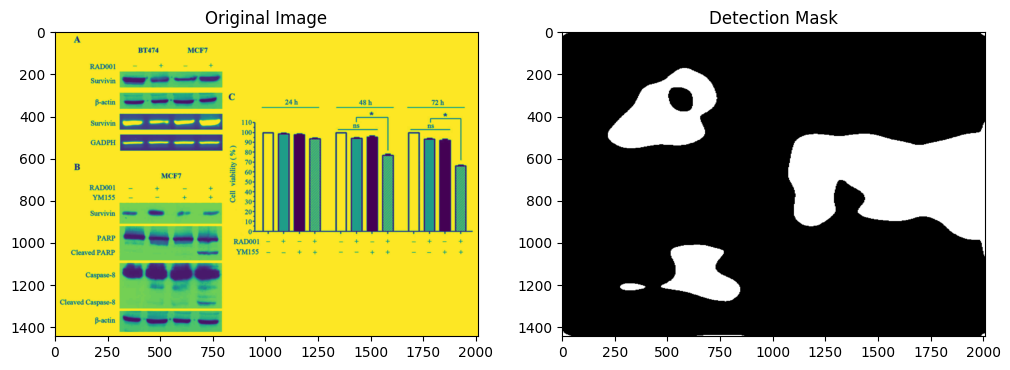

In [5]:
import matplotlib.pyplot as plt

# Load a sample from your results
sample_case = results[0]['case_id']
img_path = os.path.join(CFG.test_dir, f"{sample_case}.png") # or .jpg
if os.path.exists(img_path):
    orig = Image.open(img_path)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(orig)
    
    plt.subplot(1, 2, 2)
    plt.title("Detection Mask")
    # This assumes 'mask' from the last iteration is still in memory
    plt.imshow(mask, cmap='gray')
    plt.show()